# Proyek Regresi — Medical Cost Personal Dataset

**Notebook dibuat:** 2025-11-03 12:23:43 UTC

Notebook ini disusun untuk tugas akhir Coursera *Regression* (Supervised Learning).
Dataset: *Medical Cost Personal Dataset* (biaya medis `charges`).

Struktur notebook:
1. Deskripsi dataset
2. Load data & ringkasan
3. Eksplorasi Data (EDA)
4. Preprocessing & Feature Engineering
5. Model: Linear, RidgeCV, LassoCV, ElasticNetCV
6. Perbandingan model (CV) dan evaluasi final
7. Diagnostik & Interpretasi
8. Kesimpulan & Rekomendasi

Ganti path file jika perlu. Jalankan sel satu per satu.


In [1]:
# 0. Imports dan setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

%matplotlib inline
sns.set(style='whitegrid')


In [2]:
# 1. Load dataset (unduh otomatis dari URL)
url = "https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv"
df = pd.read_csv(url)
print("Shape:", df.shape)
df.head()


Shape: (1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## 1.a Deskripsi singkat dataset

Dataset berisi kolom:

- `age` — umur pasien (numerik)
- `sex` — jenis kelamin (male/female)
- `bmi` — body mass index (numerik)
- `children` — jumlah tanggungan anak (numerik)
- `smoker` — status perokok (yes/no)
- `region` — region (northeast, northwest, southeast, southwest)
- `charges` — biaya medis (target, numerik)

Target yang kita prediksi: `charges`.

Tujuan analisis: model regresi untuk menjelaskan/prediksi `charges`, membandingkan Linear vs Regularized models, dan menafsirkan efek fitur utama (mis. smoker, bmi, age).


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,1338.0,NaN,NaN,NaN,39.207025,14.04996,18.0,27.0,39.0,51.0,64.0
sex,1338,2,male,676,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bmi,1338.0,NaN,NaN,NaN,30.663397,6.098187,15.96,26.29625,30.4,34.69375,53.13
children,1338.0,NaN,NaN,NaN,1.094918,1.205493,0.0,0.0,1.0,2.0,5.0
smoker,1338,2,no,1064,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region,1338,4,southeast,364,NaN,NaN,NaN,NaN,NaN,NaN,NaN
charges,1338.0,NaN,NaN,NaN,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801



Missing values per column:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


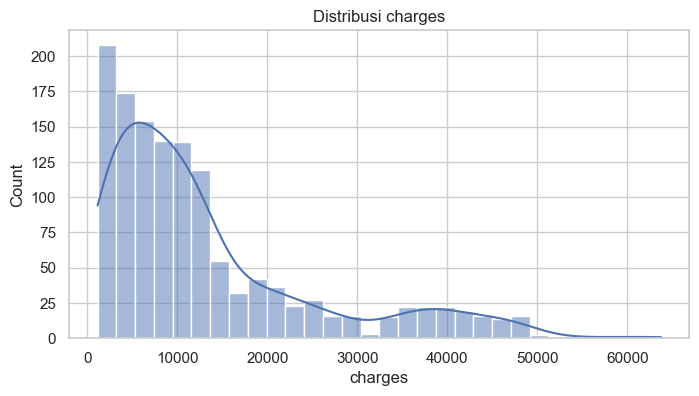

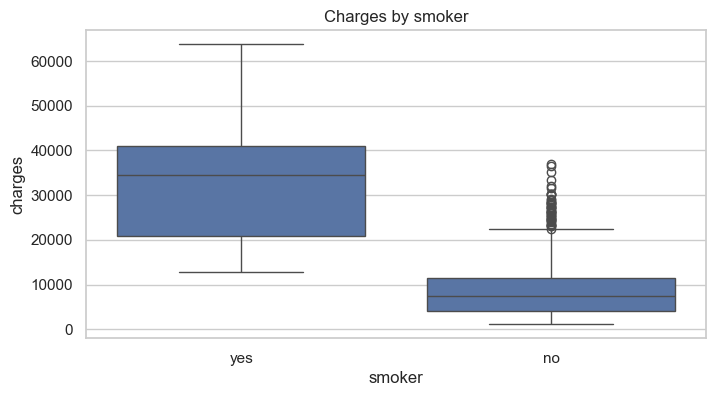

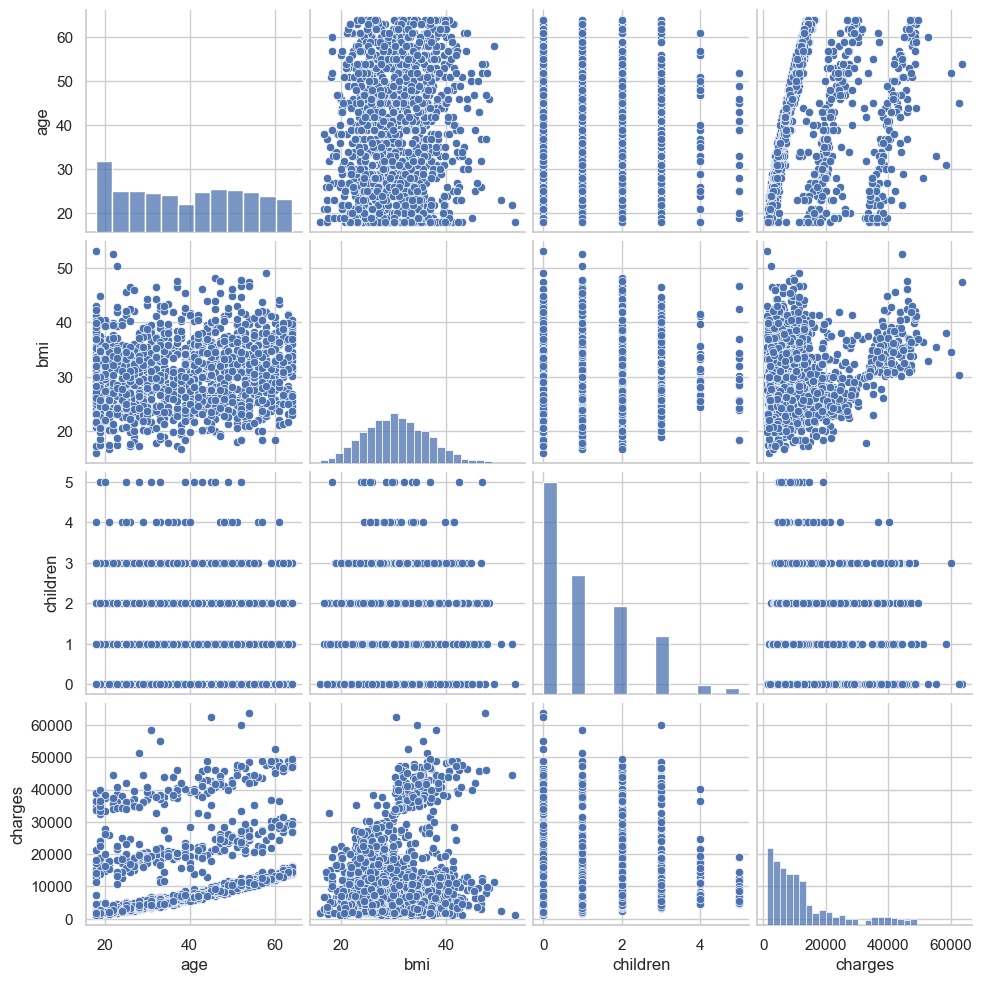

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


In [3]:
# 2. EDA cepat
display(df.describe(include='all').T)
print('\nMissing values per column:')
print(df.isna().sum())

# Distribusi target
plt.figure(figsize=(8,4))
sns.histplot(df['charges'], kde=True)
plt.title('Distribusi charges')
plt.show()

# Boxplots by smoker
plt.figure(figsize=(8,4))
sns.boxplot(x='smoker', y='charges', data=df)
plt.title('Charges by smoker')
plt.show()

# Pairplot of numeric features
sns.pairplot(df[['age','bmi','children','charges']])
plt.show()

# Correlation matrix numeric
corr = df[['age','bmi','children','charges']].corr()
display(corr)


In [4]:
# 3. Preprocessing & pipeline
target = 'charges'
features = [c for c in df.columns if c != target]

num_features = ['age','bmi','children']
cat_features = ['sex','smoker','region']

num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('ohe', OneHotEncoder(drop='first', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

# Split data
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (1070, 6) Test shape: (268, 6)


In [5]:
# 4. Build & compare models (Linear, RidgeCV, LassoCV, ElasticNetCV)
models = {
    'Linear': Pipeline([('pre', preprocessor), ('lr', LinearRegression())]),
    'RidgeCV': Pipeline([('pre', preprocessor), ('ridge', RidgeCV(alphas=np.logspace(-6,6,13), cv=5))]),
    'LassoCV': Pipeline([('pre', preprocessor), ('lasso', LassoCV(cv=5, max_iter=5000))]),
    'ElasticNetCV': Pipeline([('pre', preprocessor), ('en', ElasticNetCV(cv=5, max_iter=5000))])
}

# Function evaluasi sederhana pada test set
def eval_on_test(pipe, X_train, y_train, X_test, y_test):
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    return {
        'RMSE': np.sqrt(mean_squared_error(y_test, preds)),
        'MAE': mean_absolute_error(y_test, preds),
        'R2': r2_score(y_test, preds)
    }

results = {}
for name, pipe in models.items():
    print('Training', name)
    res = eval_on_test(pipe, X_train, y_train, X_test, y_test)
    results[name] = res

pd.DataFrame(results).T


Training Linear
Training RidgeCV
Training LassoCV
Training ElasticNetCV


,RMSE,MAE,R2
Linear,5796.284659,4181.194474,0.783593
RidgeCV,5800.464938,4193.195353,0.783281
LassoCV,5845.516113,4238.464094,0.779901
ElasticNetCV,11805.380502,9173.756723,0.102299


In [6]:
# 5. Cross-validated RMSE (5-fold) for fair comparison
kf = KFold(n_splits=5, shuffle=True, random_state=42)

def cv_rmse(pipe, X, y, cv):
    scores = cross_val_score(pipe, X, y, scoring='neg_root_mean_squared_error', cv=cv)
    return -scores.mean(), scores.std()

for name, pipe in models.items():
    mean_rmse, std_rmse = cv_rmse(pipe, X, y, kf)
    print(f"{name}: CV RMSE = {mean_rmse:.2f} +/- {std_rmse:.2f}")


Linear: CV RMSE = 6077.23 +/- 256.90
RidgeCV: CV RMSE = 6076.44 +/- 252.81
LassoCV: CV RMSE = 6078.65 +/- 247.06
ElasticNetCV: CV RMSE = 11484.54 +/- 706.48


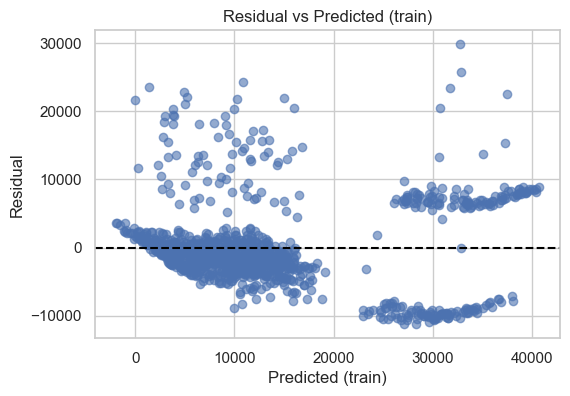

,feature,VIF
8,const,5.369250
6,region_southeast,1.613285
7,region_southwest,1.515246
5,region_northwest,1.493159
1,bmi,1.094986
0,age,1.023084
4,smoker_yes,1.011703
3,sex_male,1.006303
2,children,1.005643


In [7]:
# 6. Diagnostics: residuals and VIF (use best model after inspecting results)
best_pipe = models['RidgeCV']  # ganti berdasarkan hasil CV jika perlu
best_pipe.fit(X_train, y_train)
preds_train = best_pipe.predict(X_train)
residuals = y_train - preds_train

plt.figure(figsize=(6,4))
plt.scatter(preds_train, residuals, alpha=0.6)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Predicted (train)')
plt.ylabel('Residual')
plt.title('Residual vs Predicted (train)')
plt.show()

# Build dataframe of preprocessed features for VIF calculation
X_train_prep = pd.DataFrame(preprocessor.fit_transform(X_train))
# create column names for preprocessed features
ohe = preprocessor.named_transformers_['cat'].named_steps['ohe']
ohe_cols = list(ohe.get_feature_names_out(['sex','smoker','region']))
prep_columns = num_features + ohe_cols
X_train_prep.columns = prep_columns

# VIF
X_vif = X_train_prep.copy()
X_vif['const'] = 1
vif = pd.DataFrame()
vif['feature'] = X_vif.columns
vif['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
display(vif.sort_values('VIF', ascending=False))


In [8]:
# 7. Interpretasi: koefisien (untuk model linear-like)
# Fit a LinearRegression on preprocessed training data to inspect coefficients
lr = Pipeline([('pre', preprocessor), ('lr', LinearRegression())])
lr.fit(X_train, y_train)

# feature names
ohe = preprocessor.named_transformers_['cat'].named_steps['ohe']
feature_names = num_features + list(ohe.get_feature_names_out(['sex','smoker','region']))
coefs = lr.named_steps['lr'].coef_
coef_df = pd.DataFrame({'feature': feature_names, 'coef': coefs}).sort_values(by='coef', key=lambda col: col.abs(), ascending=False)
display(coef_df)


,feature,coef
4,smoker_yes,23651.128856
0,age,3614.975415
1,bmi,2036.228123
7,region_southwest,-809.799354
6,region_southeast,-657.864297
2,children,516.890247
5,region_northwest,-370.677326
3,sex_male,-18.591692


## 8. Kesimpulan singkat & rekomendasi

- **Model pilihan (contoh):** RidgeCV sering memberikan trade-off baik antara bias & variance.
- **Fitur penting (umum):** `smoker`, `age`, dan `bmi` biasanya punya pengaruh besar pada `charges`.
- **Langkah lanjutan:** coba transformasi `charges` (log), interaksi (smoker*bmi), model non-linear (Random Forest / Gradient Boosting), atau gunakan SHAP untuk interpretasi yang lebih kaya.

Simpan notebook ini dan jalankan sel-selnya di Jupyter. Jika mau, saya bisa:
- Menjalankan notebook dan menyimpan output aktual (grafik & file model) untuk kamu.
- Menyesuaikan isi notebook agar sesuai format spesifik Coursera (jawaban teks di markdown cells).

Katakan jika mau saya jalankan seluruh sel sekarang dan unggah hasil `.ipynb` dengan output terisi.
